In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
%matplotlib inline

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Extracting the zip file
import zipfile

file_path = '/home/FER-2013.zip'
zip_ref = zipfile.ZipFile(file_path, 'r')      #Read the contents of the zip
zip_ref.extractall('/home/FER-13')             #Extract the contents to FER-13
zip_ref.close()

In [ ]:
training_data_dir = os.path.join('/home/FER-13/train')    #Points to the training data directory
test_data_dir = os.path.join('/home/FER-13/test')         #Points to the test data directory

In [ ]:
print(os.listdir(path=training_data_dir))
print(os.listdir(path=test_data_dir))

['angry', 'neutral', 'fear', 'sad', 'surprise', 'happy', 'disgust']
['angry', 'neutral', 'fear', 'sad', 'surprise', 'happy', 'disgust']


In [ ]:
#Displays a few images from all the classes and the no. of 
#images available for every class label 

def train_test_images(dir_path):
  
  sub_dir = os.listdir(dir_path)                                                       
  fig, ax = plt.subplots(len(sub_dir), 5)                                               #displays five images for each class
  for i in range(len(sub_dir)):
    total_images = len(os.listdir(dir_path + "/" + sub_dir[i]))
    print("Total no. of images available for " + sub_dir[i] + " : " + str(total_images))
    sub_dir_images = os.listdir(dir_path + "/" + sub_dir[i])
    for j in range(5):                                                                        
      image_arr = plt.imread(dir_path + "/" + sub_dir[i] + "/" + sub_dir_images[j])     #converts image to numpy array
      ax[i, j].imshow(image_arr)                                                        #displays image
  plt.show()

  return None

Total no. of images available for angry : 3995
Total no. of images available for neutral : 4965
Total no. of images available for fear : 4097
Total no. of images available for sad : 4830
Total no. of images available for surprise : 3171
Total no. of images available for happy : 7215
Total no. of images available for disgust : 436


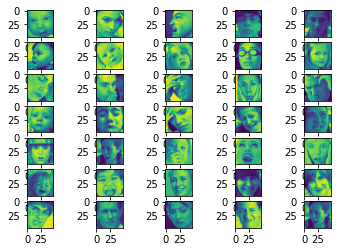

In [ ]:
#Training Data
train_test_images(training_data_dir)

Total no. of images available for angry : 958
Total no. of images available for neutral : 1233
Total no. of images available for fear : 1024
Total no. of images available for sad : 1247
Total no. of images available for surprise : 831
Total no. of images available for happy : 1774
Total no. of images available for disgust : 111


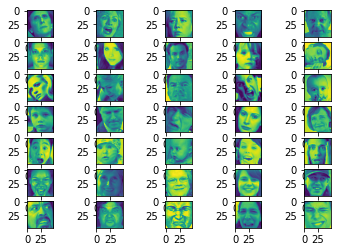

In [ ]:
#Test Data
train_test_images(test_data_dir)

In [ ]:
#Model Architecture
model = keras.models.Sequential([
           #CONV Layer - 1
           keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(48, 48, 1)),
           keras.layers.BatchNormalization(),
           keras.layers.MaxPool2D(pool_size=(2,2)),
           keras.layers.Dropout(rate=0.25),

           #CONV Layer - 2
           keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
           keras.layers.BatchNormalization(),
           keras.layers.MaxPool2D(),
           keras.layers.Dropout(rate=0.25),

           #CONV Layer - 3
           keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
           keras.layers.BatchNormalization(),
           keras.layers.MaxPool2D(),
           keras.layers.Dropout(rate=0.25),

           #CONV Layer - 4
           keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
           keras.layers.BatchNormalization(),
           keras.layers.MaxPool2D(),
           keras.layers.Dropout(rate=0.25),

           #Flatten Layer
           keras.layers.Flatten(),

           #FC Layer - 1
           keras.layers.Dense(units=256, activation='relu'),
           keras.layers.BatchNormalization(),
           keras.layers.Dropout(rate=0.25),

           #FC Layer - 2
           keras.layers.Dense(512, 'relu'),
           keras.layers.BatchNormalization(),
           keras.layers.Dropout(rate=0.25),

           #Softmax
           keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

In [ ]:
from tensorflow.keras.optimizers import Adam

#Optimizer and Loss function
model.compile(optimizer=Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Setting up the training data mini-batches for feeding into the network
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)     #normalizes the data

train_generator = train_datagen.flow_from_directory(
    directory='/home/FER-13/train',
    target_size=(48,48), 
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical', 
    shuffle=True
)

Found 28709 images belonging to 7 classes.


In [ ]:
#Setting up the test data mini-batches for feeding into the network
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    directory='/home/FER-13/test',
    batch_size=32,
    target_size=(48,48),
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 7178 images belonging to 7 classes.


In [ ]:
epochs = 30
steps_per_epoch = train_generator.n // train_generator.batch_size       #For training data        

validation_steps = test_generator.n // test_generator.batch_size         #For test data

In [ ]:
#Callback to stop training
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('val_accuracy')>0.63):
                print("\nReached 63% accuracy so cancelling training!")
                self.model.stop_training = True
                
callback = myCallback()

In [ ]:
#saves the model weights when validation accuracy increases
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/home/model_weights.h5', monitor='val_accuracy', verbose=1, save_weights_only=True, mode='max')
callbacks = [checkpoint, callback]

In [ ]:
#training the model
history = model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1, 
    callbacks=callbacks,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/30
897/897 [==============================] - 26s 20ms/step - loss: 2.2357 - accuracy: 0.2199 - val_loss: 2.0837 - val_accuracy: 0.2792

Epoch 00001: saving model to /home/model_weights.h5
Epoch 2/30
897/897 [==============================] - 18s 20ms/step - loss: 1.6310 - accuracy: 0.3759 - val_loss: 1.3948 - val_accuracy: 0.4693

Epoch 00002: saving model to /home/model_weights.h5
Epoch 3/30
897/897 [==============================] - 18s 20ms/step - loss: 1.4115 - accuracy: 0.4586 - val_loss: 1.4528 - val_accuracy: 0.4326

Epoch 00003: saving model to /home/model_weights.h5
Epoch 4/30
897/897 [==============================] - 18s 20ms/step - loss: 1.2629 - accuracy: 0.5242 - val_loss: 1.1866 - val_accuracy: 0.5484

Epoch 00004: saving model to /home/model_weights.h5
Epoch 5/30
897/897 [==============================] - 18s 20ms/step - loss: 1.1628 - accuracy: 0.5624 - val_loss: 1.2896 - val_accuracy: 0.5135

Epoch 00005: saving model to /home/model_weights.h5
Epoch 6/30
897/

In [ ]:
#Represent Model as JSON string
model_json = model.to_json()
with open('/home/model.json', 'w') as json_file:
  json_file.write(model_json)